In [1]:
import os
import imageio

import numpy as np
import pandas as pd
import scanpy as sc
import squidpy as sq
import anndata as ad

from pathlib import Path
from anndata import AnnData
from skimage.measure import label, regionprops

%load_ext autoreload
%autoreload 2

In [2]:
ad.__version__

'0.10.4'

## Load data

Download `Single_Cell_Data.csv` (Single Cell Data/Single_Cell_Data.csv) and `Risom_Mendeley_Cell_Segmentation_Files.zip` (Image Data/Risom_Mendeley_Cell_Segmentation_Files.zip) from https://data.mendeley.com/datasets/d87vg86zd8/3. 

If you unzip the latter, you'll find a folder called "Segmetation_Outlines_and_Labels_Mendeley".

In [3]:
WD = "/data/mibitof_breast_cancer"  # change as needed

In [4]:
data = pd.read_csv(os.path.join(WD, "Single_Cell_Data.csv"), index_col=None)

In [5]:
labels_files = [
    i
    for i in os.listdir(os.path.join(WD, "Segmetation_Outlines_and_Labels_Mendeley"))
    if "labels" in i
]

labels_files[:10]

['Point3102_labels.tiff',
 'Point2318_labels.tiff',
 'Point2313_labels.tiff',
 'Point3104_labels.tiff',
 'Point4118_labels.tiff',
 'Point2307_labels.tiff',
 'Point2322_labels.tiff',
 'Point5305_labels.tiff',
 'Point5306_labels.tiff',
 'Point4102_labels.tiff']

## Inspect data

In [6]:
data.iloc[:, 0:10]

,event,Point_Num,CohortNumber,cell_size,COLI,CD14,P63,Background,pS6,Ta
0,70001,2203,3,0.761562,0.000000,0.0,0.000000,0.678031,0.638869,0.571577
1,70003,2203,3,0.838842,0.000000,0.0,0.000000,0.684127,0.716979,0.441150
2,70006,2203,3,0.729244,0.000000,0.0,0.617415,0.639245,0.000000,0.816389
3,70007,2203,3,0.726701,0.000000,0.0,0.000000,0.657200,0.664403,0.545218
4,70008,2203,3,0.640285,0.000000,0.0,0.000000,0.683288,0.923153,0.511968
...,...,...,...,...,...,...,...,...,...,...
69667,38134,6206,161,0.562149,0.265940,0.0,0.000000,0.685558,0.000000,0.591055
69668,38137,6206,161,0.398084,0.000000,0.0,0.000000,0.764095,0.000000,0.892533
69669,38148,6206,161,0.433114,0.000000,0.0,0.000000,0.662494,0.605838,0.941229
69670,38169,6206,161,0.544144,0.631799,0.0,0.000000,0.799027,0.000000,0.777088


In [7]:
data.Point_Num.unique().shape

(79,)

## Build adata

In [8]:
label_id = "label"
features = [
    "cell_size",
    "COLI",
    "CD14",
    "P63",
    "Background",
    "pS6",
    "Ta",
    "CD4",
    "Au",
    "HLADRDPDQ",
    "ECADKRTCD45",
    "Nuc",
    "GZMB",
    "ECADKRTCD45GLUT1CD44",
    "Tryptase",
    "ECAD",
    "ECADKRTCD45GLUT1",
    "AR",
    "GLUT1",
    "MPO",
    "VIM",
    "CD3",
    "SMA",
    "CD56",
    "PanKRT",
    "CD11c",
    "HER2",
    "CD68",
    "P",
    "CK7",
    "CD8",
    "Na",
    "C",
    "PD1",
    "CD44",
    "HIF1a",
    "CD45",
    "X140empty",
    "FAP",
    "PDL1",
    "MMP9",
    "Ki67",
    "CK5",
    "COX2",
    "CD20",
    "FOXP3",
    "IDO1",
    "CD36",
    "ECADKRT",
    "HH3",
    "ER",
    "Ca40",
    "CD31",
    "CK5norm",
    "area",
    "eccentricity",
    "major_axis_length",
    "minor_axis_length",
    "perimeter",
]

metadata = [
    "event",
    "Point_Num",
    "CohortNumber",
    "Tissue_Type",
    "Status",
    "Tissue",
    "sublineage",
    "phenotype",
    "compartment",
    "celllineage",
    "sublineage_code",
    "phenotype_code",
    "compartment_code",
    "celllineage_code",
    "manual_gating_cellineage",
    "manual_gating_subineage",
    "manual_gating_phenotype",
    "innerduct_mask",
    "distal_mask",
    "stroma_mask",
    "periph_mask",
    "epi_mask",
    "duct_mask",
    "myoep_mask",
    "ERstatus",
    "HER2status",
    "ARstatus",
    "Ki67status",
    "pS6status",
    "GLUT1status",
    "HIF1astatus",
    "COX2status",
    "CD36status",
    "CD44status",
    "PD1status",
    "PDL1status",
    "IDO1status",
    "GZMBstatus",
    "ECADstatus",
    "MMP9status",
    "VIMstatus",
    "FAPstatus",
    "HLADRstatus",
    "CD3status",
    "SMAstatus",
    "COLIstatus",
    "CK5status",
    "CK7status",
    "P63status",
    "myoep_dist_label",
    "myoep_dist_MinDist",
    "myoep_dist_MaxDist",
    "myoep_dist_MedDist",
    "myoep_dist_MeanDist",
    "celltype_code",
    "myoep_dist_MinDist1",
    "Neighbor_dist_TUMOR",
    "Neighbor_dist_MYOEP",
    "Neighbor_dist_FIBROBLAST",
    "Neighbor_dist_ENDO",
    "Neighbor_dist_MONODC",
    "Neighbor_dist_MONO",
    "Neighbor_dist_MACS",
    "Neighbor_dist_DC",
    "Neighbor_dist_APC",
    "Neighbor_dist_MAST",
    "Neighbor_dist_CD8T",
    "Neighbor_dist_CD4T",
    "Neighbor_dist_BCELL",
    "Neighbor_dist_TCELL",
    "Neighbor_dist_NEUT",
    "Neighbor_dist_IMMUNEOTHER",
    "K10_cluster",
    "duct_edge_mask",
    "duct_mid_mask",
    "duct_core_mask",
]

In [9]:
adata_list = []
for p in data["Point_Num"].unique():
    file = [i for i in labels_files if f"Point{p}_labels.tiff" in i][0]
    labels_img = np.array(
        imageio.v2.imread(
            os.path.join(WD, "Segmetation_Outlines_and_Labels_Mendeley", file)
        )
    )
    labels_id = data[data["Point_Num"] == p][label_id]
    assert np.all(np.in1d(labels_id.unique(), np.unique(labels_img)))

    regions = regionprops(labels_img)

    spatial = np.array([props.centroid for props in regions])

    uns = {"spatial": {f"{p}": {"images": {"segmentation": labels_img}}}}
    uns["spatial"][f"{p}"]["scalefactors"] = {
        "tissue_hires_scalef": 1,
        "tissue_segmentation_scalef": 1,
        "spot_diameter_fullres": 15,
    }

    data_subset = data[data["Point_Num"] == p]
    X = data_subset[features].to_numpy()
    var_names = data_subset[features].columns.to_list()
    obs = data_subset[metadata].copy()
    obs["labels_id"] = labels_id.values.copy()
    obs.index = obs.labels_id.copy()
    obs["Point_Num"] = obs["Point_Num"].astype(str)

    adata = AnnData(X, obs=obs.copy(), dtype=X.dtype)
    adata.obsm["spatial"] = spatial
    adata.uns = uns
    adata.var_names = var_names
    adata_list.append(adata)

/dss/dsshome1/06/di93vel/.conda/envs/graph_venv/lib/python3.9/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/dss/dsshome1/06/di93vel/.conda/envs/graph_venv/lib/python3.9/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/dss/dsshome1/06/di93vel/.conda/envs/graph_venv/lib/python3.9/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/dss/dsshome1/06/di93vel/.conda/envs/graph_venv/lib/python3.9/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/dss/dsshome1/06/di93vel/.conda/envs/graph_venv/lib/python3.9/site-packages/anndata/_core/anndata.py:522: FutureWarn

/dss/dsshome1/06/di93vel/.conda/envs/graph_venv/lib/python3.9/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/dss/dsshome1/06/di93vel/.conda/envs/graph_venv/lib/python3.9/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/dss/dsshome1/06/di93vel/.conda/envs/graph_venv/lib/python3.9/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/dss/dsshome1/06/di93vel/.conda/envs/graph_venv/lib/python3.9/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/dss/dsshome1/06/di93vel/.conda/envs/graph_venv/lib/python3.9/site-packages/anndata/_core/anndata.py:522: FutureWarn

/dss/dsshome1/06/di93vel/.conda/envs/graph_venv/lib/python3.9/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/dss/dsshome1/06/di93vel/.conda/envs/graph_venv/lib/python3.9/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/dss/dsshome1/06/di93vel/.conda/envs/graph_venv/lib/python3.9/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/dss/dsshome1/06/di93vel/.conda/envs/graph_venv/lib/python3.9/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/dss/dsshome1/06/di93vel/.conda/envs/graph_venv/lib/python3.9/site-packages/anndata/_core/anndata.py:522: FutureWarn

/dss/dsshome1/06/di93vel/.conda/envs/graph_venv/lib/python3.9/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/dss/dsshome1/06/di93vel/.conda/envs/graph_venv/lib/python3.9/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/dss/dsshome1/06/di93vel/.conda/envs/graph_venv/lib/python3.9/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/dss/dsshome1/06/di93vel/.conda/envs/graph_venv/lib/python3.9/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/dss/dsshome1/06/di93vel/.conda/envs/graph_venv/lib/python3.9/site-packages/anndata/_core/anndata.py:522: FutureWarn

In [10]:
adata = ad.concat(adata_list, label="batch", uns_merge="unique")

/dss/dsshome1/06/di93vel/.conda/envs/graph_venv/lib/python3.9/site-packages/anndata/_core/anndata.py:1906: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


## Visualize adata

In [11]:
adata.obs

,event,Point_Num,CohortNumber,Tissue_Type,Status,Tissue,sublineage,phenotype,compartment,celllineage,...,Neighbor_dist_BCELL,Neighbor_dist_TCELL,Neighbor_dist_NEUT,Neighbor_dist_IMMUNEOTHER,K10_cluster,duct_edge_mask,duct_mid_mask,duct_core_mask,labels_id,batch
labels_id,,,,,,,,,,,,,,,,,,,,,
2,70001,2203,3,DCIS,ctrl,DCIS,TUMOR,TUMOR_LUMINAL,epithelial,tumor,...,0.0,0.000000,0.000,0.000000,8,0,0,0,2,0
4,70003,2203,3,DCIS,ctrl,DCIS,TUMOR,TUMOR_LUMINAL,epithelial,tumor,...,0.0,0.000000,0.000,0.000000,2,1,0,0,4,0
10,70006,2203,3,DCIS,ctrl,DCIS,TUMOR,TUMOR_LUMINAL,epithelial,tumor,...,0.0,0.000000,0.000,0.000000,2,0,1,0,10,0
11,70007,2203,3,DCIS,ctrl,DCIS,TUMOR,TUMOR_LUMINAL,epithelial,tumor,...,0.0,0.000000,0.000,0.000000,2,0,1,0,11,0
13,70008,2203,3,DCIS,ctrl,DCIS,TUMOR,TUMOR_LUMINAL,epithelial,tumor,...,0.0,0.000000,0.000,0.000000,8,1,0,0,13,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1317,38134,6206,161,DCIS,ctrl,DCIS,APC,APC,stroma,immune,...,0.0,0.000000,0.000,0.000000,10,0,0,0,1317,78
1321,38137,6206,161,DCIS,ctrl,DCIS,APC,APC,stroma,immune,...,0.0,0.083333,0.000,0.041667,10,0,0,0,1321,78
1342,38148,6206,161,DCIS,ctrl,DCIS,APC,APC,stroma,immune,...,0.0,0.045455,0.000,0.090909,10,0,0,0,1342,78


/dss/dsshome1/06/di93vel/.conda/envs/graph_venv/lib/python3.9/site-packages/squidpy/pl/_spatial_utils.py:747: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if c is not None and c in adata.obs and is_categorical_dtype(adata.obs[c]):
/dss/dsshome1/06/di93vel/.conda/envs/graph_venv/lib/python3.9/site-packages/squidpy/pl/_spatial_utils.py:388: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if key not in adata.obs or not is_categorical_dtype(adata.obs[key]):
/dss/dsshome1/06/di93vel/.conda/envs/graph_venv/lib/python3.9/site-packages/squidpy/pl/_spatial_utils.py:471: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(color_source_vector):
/dss/dsshome1/06/di93vel/.conda/envs/graph_venv/lib/

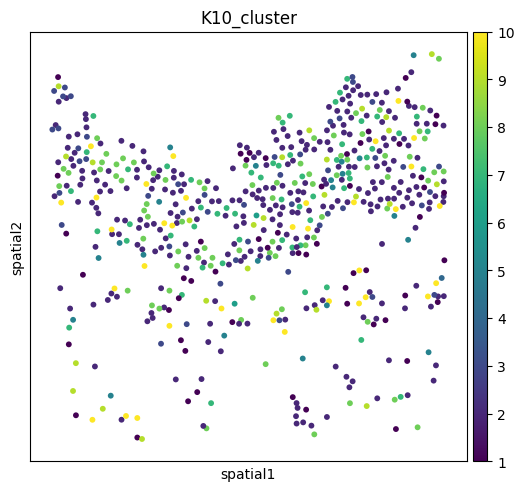

In [12]:
sq.pl.spatial_scatter(
    adata, library_key="Point_Num", library_id="2203", color="K10_cluster", img=False
)

/dss/dsshome1/06/di93vel/.conda/envs/graph_venv/lib/python3.9/site-packages/squidpy/pl/_spatial_utils.py:747: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if c is not None and c in adata.obs and is_categorical_dtype(adata.obs[c]):
/dss/dsshome1/06/di93vel/.conda/envs/graph_venv/lib/python3.9/site-packages/squidpy/pl/_spatial_utils.py:388: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if key not in adata.obs or not is_categorical_dtype(adata.obs[key]):
/dss/dsshome1/06/di93vel/.conda/envs/graph_venv/lib/python3.9/site-packages/squidpy/pl/_spatial_utils.py:471: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(color_source_vector):
/dss/dsshome1/06/di93vel/.conda/envs/graph_venv/lib/

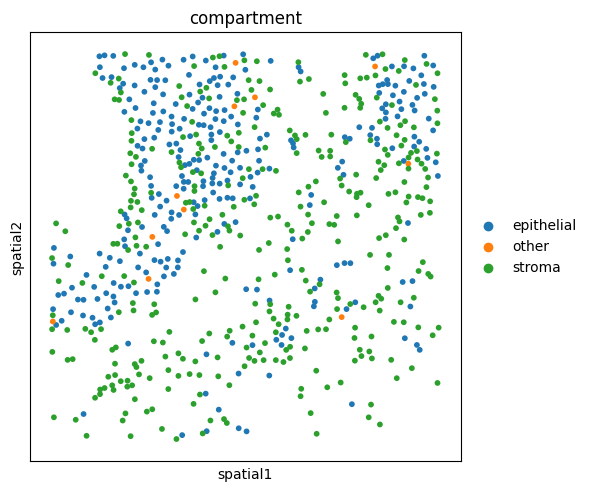

In [13]:
sq.pl.spatial_scatter(
    adata, library_key="Point_Num", library_id="6206", color="compartment", img=False
)

/dss/dsshome1/06/di93vel/.conda/envs/graph_venv/lib/python3.9/site-packages/squidpy/pl/_spatial_utils.py:747: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if c is not None and c in adata.obs and is_categorical_dtype(adata.obs[c]):
/dss/dsshome1/06/di93vel/.conda/envs/graph_venv/lib/python3.9/site-packages/squidpy/pl/_spatial_utils.py:388: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if key not in adata.obs or not is_categorical_dtype(adata.obs[key]):
/dss/dsshome1/06/di93vel/.conda/envs/graph_venv/lib/python3.9/site-packages/squidpy/pl/_spatial_utils.py:471: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(color_source_vector):
/dss/dsshome1/06/di93vel/.conda/envs/graph_venv/lib/

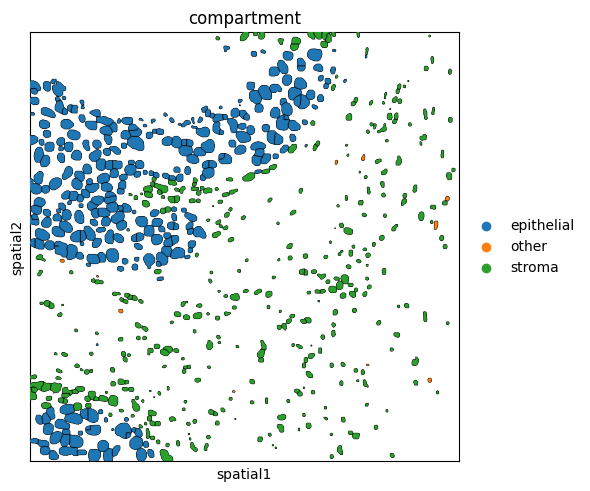

In [14]:
sq.pl.spatial_segment(
    adata,
    library_key="Point_Num",
    library_id="6206",
    seg_cell_id="labels_id",
    seg_outline=True,
    color="compartment",
    img=False,
)

## Save adata

In [ ]:
adata.write(os.path.join(WD, "adata_processed.h5ad")